In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Ý nghĩa các tham số trong mô hình ARIMA(p,d,q):
- p: số lượng *lag* quan sát trong mô hình (thứ tự của *lag*).
- d: số lần quan sát bị thay đổi (bậc differencing).
- q: kích thước của "window" moving average (bậc của moving average).

In [2]:
df_data = pd.read_csv("https://raw.githubusercontent.com/lhminhtuan2000/PTDLUD_DATH_2/main/airbnb-listings_new-york.csv", sep=';', low_memory=False)
df_data.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,13494898,https://www.airbnb.com/rooms/13494898,20170502132028,2017-05-04,Modern 1BR apartment amazing location in Chelsea,This modern apartment is full of New York char...,NaN,This modern apartment is full of New York char...,none,NaN,...,10.0,10.0,10.0,NaN,NaN,flexible,1,0.29,"40.74032236139562,-74.00264894520818","Host Has Profile Pic,Is Location Exact"
1,7859723,https://www.airbnb.com/rooms/7859723,20170502132028,2017-05-04,Spacious Studio in Chelsea,Large and very clean studio on a beautiful tre...,NaN,Large and very clean studio on a beautiful tre...,none,NaN,...,10.0,10.0,10.0,NaN,NaN,strict,1,0.60,"40.74452858803597,-73.9998811278712","Host Has Profile Pic,Host Identity Verified,Is..."
2,137558,https://www.airbnb.com/rooms/137558,20170502132028,2017-05-05,MINIMALIST APT. HIGH-LINE AREA,NaN,This is the most charming place in the area. T...,This is the most charming place in the area. T...,none,NaN,...,10.0,10.0,9.0,NaN,NaN,strict,1,0.20,"40.752836564513,-74.0071511604528","Host Has Profile Pic,Is Location Exact"
3,3915771,https://www.airbnb.com/rooms/3915771,20170502132028,2017-05-05,Furnished Studio with Loft CHELSEA,Lovely studio apartment in the heart of Manhat...,This is an amazing studio right in the center ...,Lovely studio apartment in the heart of Manhat...,none,"Chelsea, for those who don't know NYC, is amaz...",...,10.0,10.0,9.0,NaN,NaN,moderate,1,0.53,"40.74461572374567,-74.00046825033714","Host Has Profile Pic,Host Identity Verified"
4,2537383,https://www.airbnb.com/rooms/2537383,20170502132028,2017-05-05,New York City - A Love Affair!,"Charming, very quaint, sunny 1 bdrm apt., 4th ...","The apartment is a REAL one bedroom, unlike ma...","Charming, very quaint, sunny 1 bdrm apt., 4th ...",none,Chelsa is one of the most sought after neighbo...,...,10.0,10.0,10.0,NaN,NaN,strict,1,0.98,"40.74122935887343,-74.0026704259246","Host Has Profile Pic,Host Identity Verified,Is..."


In [3]:
df_data.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

In [4]:
# Chọn 1 cột nhãn thời gian và 1 cột có giá trị dự đoán theo thời gian
col = ['Last Review', 'Price']
# Lọc ra các dữ liệu cần thiết
df = df_data[df_data['Room Type'] == 'Entire home/apt']
df = df[df['Neighbourhood'] == "Chelsea"]
# Xoá missing values
df = df[col].dropna()
df

,Last Review,Price
0,2017-04-06,110.0
1,2017-04-10,120.0
2,2017-04-13,199.0
5,2017-01-05,395.0
6,2017-01-29,140.0
...,...,...
19171,2017-01-01,125.0
19172,2017-04-14,650.0
19175,2015-07-17,125.0
19176,2017-04-09,144.0


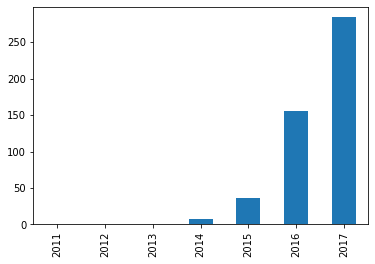

In [5]:
# Phân bố 'Last Review' theo các năm
years =  pd.to_datetime(df['Last Review'], format='%Y-%m-%d', errors='coerce').dt.year
years.value_counts().sort_index().plot.bar()

-> Ta thấy năm 2017 có nhiều dữ liệu hơn nên chọn từ đây

In [6]:
df = df[df['Last Review'].str.contains("2017")]
df

,Last Review,Price
0,2017-04-06,110.0
1,2017-04-10,120.0
2,2017-04-13,199.0
5,2017-01-05,395.0
6,2017-01-29,140.0
...,...,...
19166,2017-04-15,207.0
19171,2017-01-01,125.0
19172,2017-04-14,650.0
19176,2017-04-09,144.0


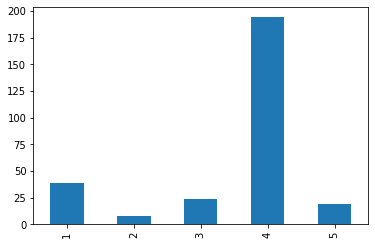

In [7]:
# Phân bố 'Last Review' theo các tháng trong năm 2017
months =  pd.to_datetime(df['Last Review'], format='%Y-%m-%d', errors='coerce').dt.month
months.value_counts().sort_index().plot.bar()

# Mục tiêu dự đoán

Giá của các "apt" ở "Chelsea" trong các tháng tiếp theo năm 2017 bằng cách xây dựng mô hình ARIMA

In [8]:
df = df.sort_values(by='Last Review')
df

,Last Review,Price
10215,2017-01-01,160.0
5673,2017-01-01,149.0
4331,2017-01-01,200.0
4360,2017-01-01,180.0
9351,2017-01-01,500.0
...,...,...
10219,2017-05-02,229.0
7093,2017-05-02,195.0
14149,2017-05-02,250.0
6553,2017-05-03,189.0


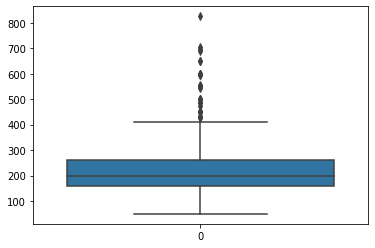

In [9]:
# Kiểm tra outliers
sns.boxplot(data = df['Price'])

In [10]:
# Remove outlier
df = df[df['Price'] <= 400]
df

,Last Review,Price
10215,2017-01-01,160.0
5673,2017-01-01,149.0
4331,2017-01-01,200.0
4360,2017-01-01,180.0
19171,2017-01-01,125.0
...,...,...
10219,2017-05-02,229.0
7093,2017-05-02,195.0
14149,2017-05-02,250.0
6553,2017-05-03,189.0


In [11]:
# Xoá cột 'Last Review'
df = df.drop(columns=['Last Review'])
# Reset index
df.reset_index(inplace=True)
# Xoá index cũ
df.drop(columns=['index'], inplace=True)
df

,Price
0,160.0
1,149.0
2,200.0
3,180.0
4,125.0
...,...
249,229.0
250,195.0
251,250.0
252,189.0


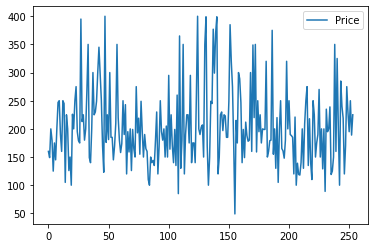

In [12]:
# Xem biến động 'Price'
df.plot()

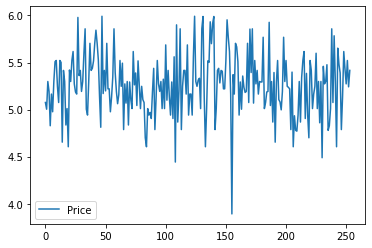

In [13]:
# Scaled data
df = np.log(df)
df.plot()

Sau khi dùng hàm **logarithm** thì dữ liệu đã bớt biến động

Tách dữ liệu thành tập train (phần còn lại) và test (20 dòng cuối)

In [14]:
msk = (df.index < len(df) -20)
df_train = df[msk].copy()
df_test = df[~msk].copy()

## Bước 1: Kiểm tra tập dữ liệu có **Stationary** hay không?

Theo biểu đồ bên trên thì dữ liệu có vẻ như đã Stationary

Ta có thể kiểm tra lại bằng cách sau đây

### Augmented Dickey Fuller Test (ADF Test)
- H0: Non-stationary
- H1: Stationary

In [15]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df_train)
print('ADF Statistic: %f' % adf_test[0])
print(f'p-value: {adf_test[1]}')
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.215787
p-value: 1.8355204056146783e-15
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573


Ta thấy: p-value < *alpha* = 0.05

=> Bác bỏ H0 => Stationary

Vậy ta xác định phần I trong mô hình ARIMA(p, d, q) => d = 0

## Bước 2: Xác định tham số p, q trong mô hình ARIMA

Vẽ đồ thị ACF và PACF

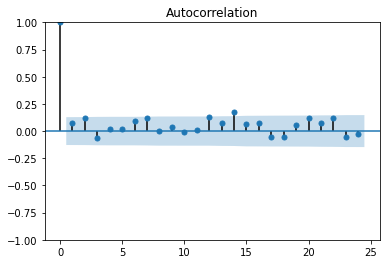

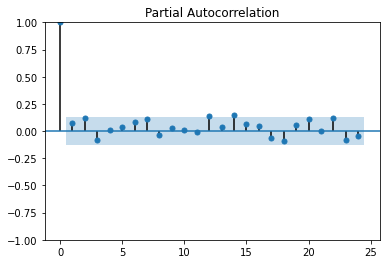

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_diff = plot_acf(df_train)

pacf_diff = plot_pacf(df_train)

PACF có 1 spike lớn ở lag 1 và có các spike nhỏ hơn => p = 1

Nhìn các lag ở ACF nằm ở rìa vùng xanh. Dùng lag 13 do có độ corel khá cao => q = 13

=> ARIMA(1, 0, 13)

Lựa chọn tham số phù hợp cho mô hình ARIMA khá là khó, ta nên thử nhiều lần

## Bước 3: Xây dựng mô hình ARIMA

In [17]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(1,0,13))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  234
Model:                ARIMA(1, 0, 13)   Log Likelihood                 -61.418
Date:                Sat, 31 Dec 2022   AIC                            154.837
Time:                        15:44:19   BIC                            210.122
Sample:                             0   HQIC                           177.128
                                - 234                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2586      0.046    115.056      0.000       5.169       5.348
ar.L1          0.9003      0.094      9.539      0.000       0.715       1.085
ma.L1         -0.8547      0.115     -7.446      0.0

Chú ý giá trị AIC và p>|z|

## Bước 4: Áp dụng mô hình để dự đoán

Kiểm tra xem mô hình có đầy đủ thông tin cần thiết chưa

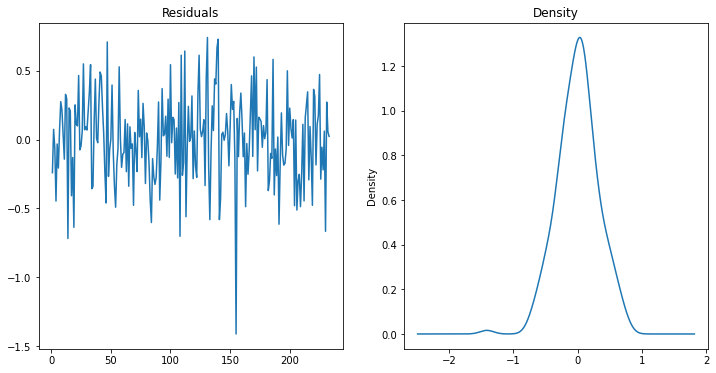

In [18]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(6)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

- Residuals dao động không theo quy luật nào
- Density có phân phối chuẩn với mean = 0

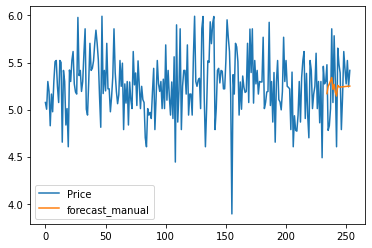

In [19]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

Theo mô hình dự đoán trên
- Dữ liệu *predict* dao động nhẹ với biên độ nhỏ và đứng yên về sau
- Dữ liệu *actual* dao động liên tục với biên độ khá lớn

### Optional: Auto-fit mô hình ARIMA

Python có hỗ trợ thư viện có sẵn để lựa chọn các tham số cho mô hình ARIMA

In [20]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [22]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -76.128
Date:                Sat, 31 Dec 2022   AIC                            158.257
Time:                        15:44:32   BIC                            168.622
Sample:                             0   HQIC                           162.436
                                - 234                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   5728.941      0.000       1.000       1.000
ma.L1         -0.9349      0.023    -39.881      0.000      -0.981      -0.889
sigma2         0.1086      0.008     13.267      0.000       0.093       0.125
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                18.94
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.30
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Bước 5: Đánh giá mô hình dự đoán

Ta có 2 mô hình cần đánh giá: ARIMA(1,0,13) và ARIMA(1,0,1)

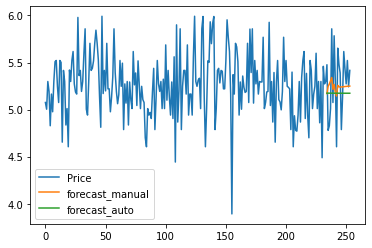

In [23]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot()

Đường màu xanh lá là dữ liệu predict của ARIMA(1,0,1). Dữ liệu đứng yên liên tục => Giá cho thuê đóng băng

In [24]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

mae_auto = mean_absolute_error(df_test, forecast_test_auto)
mape_auto = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse_auto = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

In [25]:
df_evaluation = {'MODEL': ["ARIMA(1,0,13)", "AUTO ARIMA"], 'MAE': [mae, mae_auto], 'MAPE': [mape, mape_auto], 'RMSE': [rmse, rmse_auto]}
evaluation = pd.DataFrame(data=df_evaluation)
evaluation

,MODEL,MAE,MAPE,RMSE
0,"ARIMA(1,0,13)",0.285581,0.054576,0.330329
1,AUTO ARIMA,0.308629,0.058239,0.357678


2 mô hình trên khá tương đồng do có độ lỗi xấp xỉ nhau

Vậy theo 2 mô hình trên thì giá cho thuê sẽ tiếp tục đóng băng trong 1 vài tháng tới

***NOTE***: Chọn dataset sai!!!

# *Nguồn tham khảo*

[How to Build ARIMA Model in Python for time series forecasting?](https://www.projectpro.io/article/how-to-build-arima-model-in-python/544)
